# Clustering Wave File

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Load audiofile
y, sr = librosa.load("data/test.wav")
seconds = len(y)/22050

# Short-Time Fourier Transform (STFT)
S = librosa.stft(y)
seconds = len(y)/22050
# Convert amplitudes in decibel
S_dB = librosa.amplitude_to_db(np.abs(S), ref=np.max)

# Plotting
plt.figure(figsize=(10, 6))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.show()

# Failed: Clustering Based on Engineered Features

In [ ]:
import librosa
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering, KMeans, MiniBatchKMeans, Birch

# Load the audio file
y, sr = librosa.load('data/test.wav')

# Calculate the Short-Time Fourier Transform (STFT)
D = librosa.stft(y)

# Convert the spectrogram to the Mel scale
S = librosa.feature.melspectrogram(S=D, sr=sr)

# Extract Spectral Features
spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
spectral_contrast = librosa.feature.spectral_contrast(S=D, sr=sr)
spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y)
mfccs = librosa.feature.mfcc(S=librosa.power_to_db(np.abs(S)), sr=sr, n_mfcc=13)

# Transpose features so that each row corresponds to a time frame
spectral_centroid = spectral_centroid.T
spectral_bandwidth = spectral_bandwidth.T
spectral_contrast = spectral_contrast.T
spectral_rolloff = spectral_rolloff.T
zero_crossing_rate = zero_crossing_rate.T
mfccs = mfccs.T

# Create a DataFrame with all the features
# We will use `pd.concat` to combine the features along the second axis (columns)
df = pd.concat([
    pd.DataFrame(spectral_centroid, columns=['spectral_centroid']),
    pd.DataFrame(spectral_bandwidth, columns=['spectral_bandwidth']),
    pd.DataFrame(spectral_contrast, columns=[f'spectral_contrast_{i}' for i in range(spectral_contrast.shape[1])]),
    pd.DataFrame(spectral_rolloff, columns=['spectral_rolloff']),
    pd.DataFrame(zero_crossing_rate, columns=['zero_crossing_rate']),
    pd.DataFrame(mfccs, columns=[f'mfcc_{i+1}' for i in range(mfccs.shape[1])])
], axis=1)

# Display the DataFrame
#display(df)

# Clustering
clustering = KMeans(n_clusters=3).fit_predict(df)

# Plotting the results
plt.plot(clustering, '.')

# Trying Out X-Vectors

,start,end,speaker
0,0.0,0.5,Speaker 1
1,0.5,1.0,Speaker 1
2,1.0,1.5,Speaker 1
3,1.5,2.0,Speaker 1
4,2.0,2.5,Speaker 1
5,2.5,3.0,Speaker 1
6,3.0,3.5,Speaker 1
7,3.5,4.0,Speaker 1
8,4.0,4.5,Speaker 1
9,4.5,5.0,Speaker 1


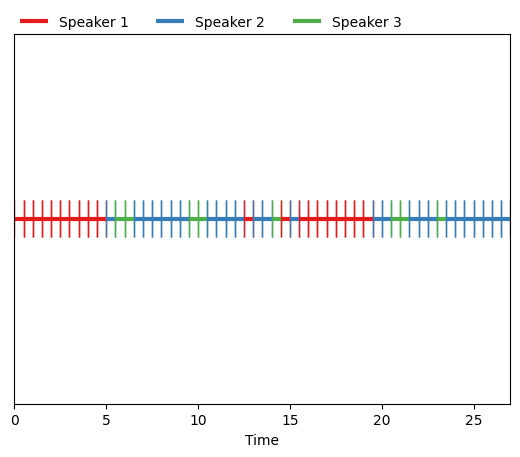

In [52]:
import torch
import torchaudio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from speechbrain.pretrained import SpeakerRecognition
from sklearn.cluster import AgglomerativeClustering, KMeans, MiniBatchKMeans, Birch, DBSCAN
from pyannote.core import Segment, Annotation, notebook

# Load pre-trained x-vector model
xvector_model = SpeakerRecognition.from_hparams(
    source="speechbrain/spkrec-xvect-voxceleb",
    savedir="pretrained_models/spkrec-xvect-voxceleb"
)

# Load audio file (fs is sampling rate)
signal, fs = torchaudio.load("data/test.wav")

# Ensure the audio is mono and 16kHz
if signal.shape[0] > 1:
    signal = torch.mean(signal, dim=0, keepdim=True)

if fs != 16000:
    signal = torchaudio.transforms.Resample(fs, 16000)(signal)

# Define segment length and step
segment_length = .5  # adjust to preference
step = .5  # adjust to preference
segment_length_samples = int(segment_length * 16000)
step_samples = int(step * 16000)

# Extract x-vectors for each segment
xvectors = []
segments = []
for start in range(0, signal.shape[1] - segment_length_samples, step_samples):
    segment = signal[:, start:start + segment_length_samples]
    xvector = xvector_model.encode_batch(segment)
    xvectors.append(xvector.squeeze().detach().numpy())
    segments.append(Segment(start / 16000, (start + segment_length_samples) / 16000))

xvectors = np.array(xvectors)

# Perform agglomerative clustering
num_speakers = 3  # Change this number based on expected number of speakers
labels = AgglomerativeClustering(n_clusters=num_speakers).fit_predict(xvectors)

# Create a pyannote annotation for visualization and output
annotation = Annotation()
for i, label in enumerate(labels):
    annotation[segments[i]] = f"Speaker {label + 1}"

# Display the diarization result
notebook.plot_annotation(annotation, time=True, legend=True)

#Convert to Pandas DataFrame for easier handling
df = pd.DataFrame({
    "start": [segment.start for segment in segments],
    "end": [segment.end for segment in segments],
    "speaker": [f"Speaker {label + 1}" for label in labels]
})

benchmark = pd.read_csv("data/test_labels.csv", header=None)
df

In [ ]:
import librosa
import matplotlib.pyplot as plt
import numpy as np

# Load audiofile (sr is sample rate)
y, sr = librosa.load("data/test.wav")
x_axis = np.array(range(len(y)))/sr

# Short-Time Fourier Transform (STFT)
S = librosa.stft(y)

# Convert amplitudes in decibel
S_dB = librosa.amplitude_to_db(np.abs(S), ref=np.max)

# Plotting
plt.plot(x_axis,y)